#### Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import os
for dirname, _, filenames in os.walk('./Desktop/Библиотеки Python/jupiter/Course_project/Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Подключаем предупреждения

In [3]:
import warnings
warnings.filterwarnings('ignore')

#### Устанавливаем значения(шрифт и размер)

In [4]:
matplotlib.rcParams.update({'font.size': 14})

#### Пути к директориям и файлам

In [5]:
Train_df = pd.read_csv('C:/Users/rsh/Desktop/Библиотеки Python/jupiter/Course_project/Dataset/train.csv')
Test_df = pd.read_csv('C:/Users/rsh/Desktop/Библиотеки Python/jupiter/Course_project/Dataset/test.csv')

#### Задаем функцию для подсчета метрик

In [6]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### Загрузка данных

#### Описание датасета

- Id - идентификационный номер квартиры
- DistrictId - идентификационный номер района
- Rooms - количество комнат
- Square - площадь
- LifeSquare - жилая площадь
- KitchenSquare - площадь кухни
- Floor - этаж
- HouseFloor - количество этажей в доме
- HouseYear - год постройки дома
- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
- Social_1, Social_2, Social_3 - социальные показатели местности
- Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
- Shops_1, Shops_2-показатели, связанные с наличием магазинов, торговых центров
- Price - цена квартиры

#### Обзор данных

In [7]:
Train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [8]:
Test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


#### Приведение типов

In [9]:
Train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [10]:
Train_df['Id'] = Train_df['Id'].astype(str)
Train_df['Id'].dtype

dtype('O')

In [11]:
Test_df['Id'] = Test_df['Id'].astype(str)
Test_df['Id'].dtype

dtype('O')

In [12]:
Train_df.dtypes.value_counts()

int64      8
float64    8
object     4
dtype: int64

In [13]:
Train_df.shape

(10000, 20)

In [14]:
Test_df.shape

(5000, 19)

In [15]:
Train_df.shape[1] - 1 == Test_df.shape[1]

True

In [16]:
num_feat = list(Train_df.select_dtypes(exclude='object').columns)
obj_feat = list(Train_df.select_dtypes(include='object').columns)
target = 'Price'

In [17]:
sample_sub_df = pd.read_csv('C:/Users/rsh/Desktop/Библиотеки Python/jupiter/Course_project/Dataset/sample_submission.csv')

#### Поиск признаков с выбросами

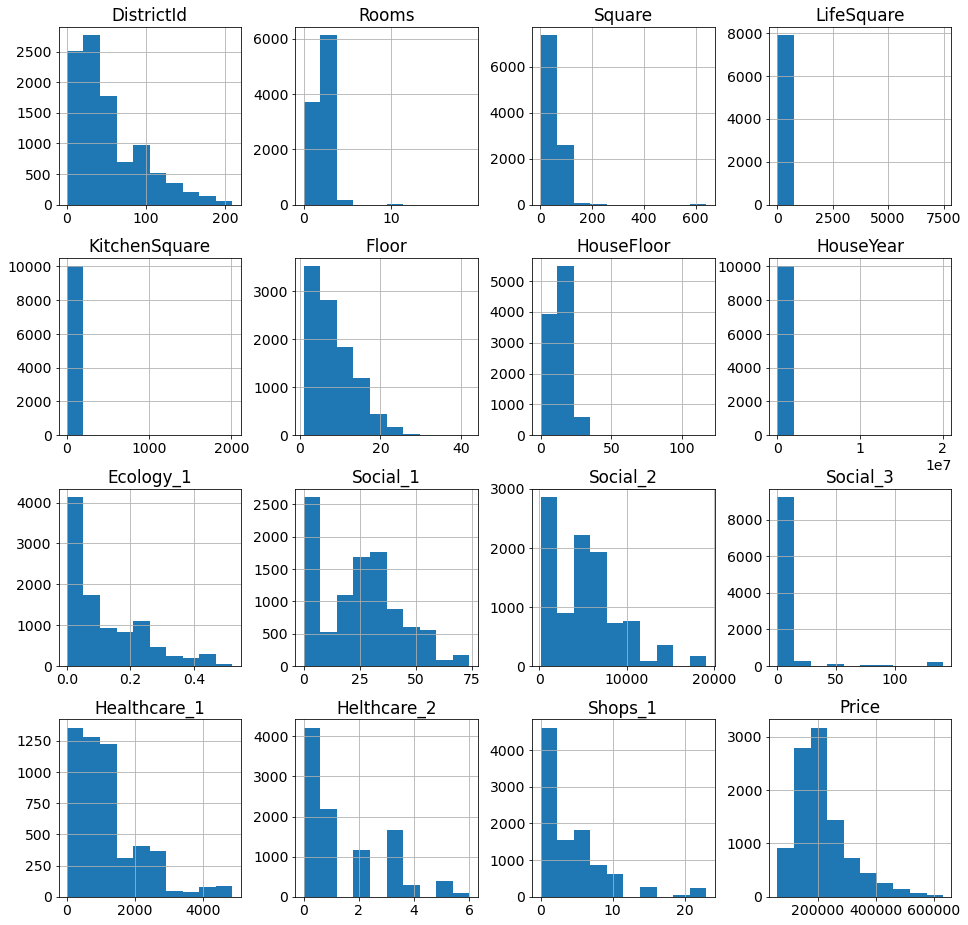

In [18]:
Train_df[num_feat].hist(
    figsize=(16,16)
)
plt.show()

#### Обработка выбросов

In [19]:
Train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
LifeSquare,7887.0,37.199645,86.241209,0.370619,22.769832,32.781260,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01
Social_1,10000.0,24.687000,17.532614,0.000000,6.000000,25.000000,36.000000,7.400000e+01


#### Rooms

In [20]:
Train_df[(Train_df['Rooms']<1) | (Train_df['Rooms']>5)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2004,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
2194,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646
2728,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863
3780,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788
5894,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
6088,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704
6401,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.918007
7644,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
7929,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
8794,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416


In [21]:
Train_df['Rooms'].mode()[0]

2.0

In [22]:
Train_df.loc[(Train_df['Rooms']<1) | (Train_df['Rooms']>5), 'Rooms'] = Train_df['Rooms'].mode()[0]
Test_df.loc[(Test_df['Rooms']<1) | (Test_df['Rooms']>5), 'Rooms'] = Test_df['Rooms'].mode()[0]

#### Square

In [23]:
Train_df.nlargest(10, 'Square')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9229,11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562
726,28,9,2.0,604.705972,NaN,1.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.242538
7010,2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830
1906,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.882666
7644,7917,27,2.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
1776,16568,27,4.0,200.334539,201.627361,25.0,1,2.0,2013,0.041116,B,B,53,14892,4,NaN,1,4,B,528560.506016
9307,4249,23,5.0,198.930182,123.139863,10.0,1,2.0,2011,0.014073,B,B,2,475,0,NaN,0,0,B,345665.209100
1606,3718,56,3.0,190.857689,107.376164,19.0,7,3.0,2007,0.000000,B,B,23,5067,4,NaN,2,6,B,338644.075979
8011,3233,129,4.0,186.692602,87.487080,32.0,3,3.0,2011,0.020741,B,B,24,5613,5,1340.0,2,5,B,423443.464367
2790,15947,129,4.0,185.906396,84.830074,31.0,5,3.0,2015,0.020741,B,B,24,5613,5,1340.0,2,5,B,340273.238253


In [24]:
Train_df.loc[(Train_df['Square']<15) | (Train_df['Square']>300), 'Square'] = Train_df['Square'].median()

#### Life Square

In [25]:
Train_df.nlargest(10, 'LifeSquare')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
8000,16550,27,3.0,81.694417,7480.592129,1.0,9,17.0,2016,0.017647,B,B,2,469,0,NaN,0,0,B,217357.492366
9229,11602,30,2.0,52.513310,638.163193,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562
5183,15886,85,3.0,78.059331,461.463614,10.0,12,16.0,1998,0.037178,B,B,52,11217,1,2300.0,1,7,B,394253.299978
7010,2307,102,1.0,52.513310,410.639749,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830
357,14990,23,2.0,48.449873,263.542020,5.0,6,5.0,1972,0.075779,B,B,6,1437,3,NaN,0,2,B,141780.231857
1906,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.882666
7644,7917,27,2.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
1776,16568,27,4.0,200.334539,201.627361,25.0,1,2.0,2013,0.041116,B,B,53,14892,4,NaN,1,4,B,528560.506016
5283,11055,151,1.0,174.649522,174.837082,15.0,10,12.0,1958,0.236108,B,B,16,3893,27,NaN,3,10,B,232766.187698
8872,5300,30,3.0,169.509941,170.713651,1.0,2,2.0,2018,0.000078,B,B,22,6398,141,1046.0,3,23,B,200800.673767


In [26]:
Train_df.loc[(Train_df['LifeSquare']<15) | (Train_df['LifeSquare']>280), 'LifeSquare'] = Train_df['Square']
Test_df.loc[(Test_df['LifeSquare']<15) | (Test_df['LifeSquare']>280), 'LifeSquare'] = Test_df['Square']

#### Kitchen Square

In [27]:
Train_df.nlargest(10, 'KitchenSquare')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9520,14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A,108337.484207
6505,14679,81,1.0,32.276663,19.278394,1970.0,6,1.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,105539.556275
286,2737,27,3.0,123.430072,125.806981,123.0,5,10.0,2015,0.017647,B,B,2,469,0,NaN,0,0,B,234194.837047
5002,7441,62,3.0,114.734473,112.589083,112.0,3,3.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,315245.521059
7733,12552,58,3.0,116.405693,113.109653,112.0,3,3.0,2016,0.437885,B,B,23,5735,3,1084.0,0,5,B,296165.936689
2454,12390,72,3.0,97.490674,99.323558,96.0,22,25.0,2019,0.210473,B,B,11,2398,2,1994.0,3,0,B,445074.956552
2785,6569,27,1.0,38.220258,18.716856,84.0,4,17.0,2018,0.011654,B,B,4,915,0,NaN,0,0,B,99079.960518
2831,12507,54,2.0,79.810535,79.578961,78.0,10,15.0,2014,0.006076,B,B,30,5285,0,645.0,6,6,B,438708.707579
3956,4966,96,3.0,78.445675,47.146757,75.0,9,12.0,1977,0.041116,B,B,53,14892,4,NaN,1,4,B,290354.484070
5273,13703,42,1.0,38.071692,19.723548,73.0,9,10.0,2006,0.158249,B,B,21,5731,0,NaN,1,0,B,160488.033165


In [28]:
Train_df.loc[Train_df['KitchenSquare']<3, 'KitchenSquare'] = 3
Test_df.loc[Test_df['KitchenSquare']<3, 'KitchenSquare'] = 3

In [29]:
Train_df.loc[Train_df['KitchenSquare']>Train_df['LifeSquare'], 'KitchenSquare'] = Train_df['KitchenSquare'].median()
Test_df.loc[Test_df['KitchenSquare']>Test_df['LifeSquare'], 'KitchenSquare'] = Test_df['KitchenSquare'].median()

#### HouseFloor, Floor

In [30]:
Train_df.nlargest(10, 'HouseFloor')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1678,78,30,2.0,65.773749,66.811789,3.0,8,117.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,207248.370520
746,9300,74,2.0,71.747869,74.579809,9.0,5,99.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,243329.912579
4657,10806,5,1.0,51.944587,48.709601,3.0,6,99.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,296127.115515
4987,1674,76,2.0,74.344672,41.044132,5.0,42,48.0,2016,0.000000,B,B,7,1660,39,1786.0,1,5,B,411691.504766
5031,7453,24,3.0,126.621358,62.455481,12.0,22,48.0,2011,0.111627,B,B,50,12238,8,1970.0,2,3,B,179396.521035
5259,6502,20,1.0,126.389517,103.637322,14.0,22,47.0,2012,0.019509,B,B,37,7687,11,176.0,5,5,B,450706.552655
646,5279,93,2.0,60.804544,30.923827,11.0,5,45.0,2016,0.050900,B,B,43,10621,1,30.0,2,3,B,213171.135199
765,6589,30,1.0,62.110823,52.812128,4.0,31,44.0,2009,0.000078,B,B,22,6398,141,1046.0,3,23,B,117647.461002
761,7496,30,1.0,117.370746,102.187199,6.0,14,40.0,2011,0.000078,B,B,22,6398,141,1046.0,3,23,B,521829.550445
1038,15270,31,2.0,81.042938,46.633001,16.0,15,40.0,1977,0.151346,B,A,32,5889,10,830.0,4,1,B,547586.080087


In [31]:
Train_df.loc[(Train_df['HouseFloor']<2) | (Train_df['HouseFloor']>50), 'HouseFloor'] = Train_df['HouseFloor'].mode()[0]
Test_df.loc[(Test_df['HouseFloor']<2) | (Test_df['HouseFloor']>50), 'HouseFloor'] = Test_df['HouseFloor'].mode()[0]

In [32]:
Train_df[Train_df['Floor']>Train_df['HouseFloor']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
17,1190,8,2.0,49.396000,28.299600,5.0,6,5.0,1962,0.458174,B,A,26,4439,1,1130.0,1,5,B,186971.926566
19,367,45,1.0,42.367289,40.012529,3.0,16,14.0,2015,0.195781,B,B,23,5212,6,NaN,3,2,B,250466.980777
21,8471,20,3.0,75.611065,47.494621,8.0,11,9.0,1976,0.019509,B,B,37,7687,11,176.0,5,5,B,366916.246494
25,4521,6,2.0,65.409965,NaN,3.0,18,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,191205.272608
33,847,74,2.0,73.314975,74.131261,3.0,7,6.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,254005.381863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9930,3659,27,2.0,56.812696,NaN,3.0,11,9.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,133388.930997
9953,7659,57,1.0,38.485252,22.550608,8.0,19,17.0,1992,0.133215,B,B,49,11395,3,1406.0,3,4,A,183485.284995
9968,9920,1,3.0,86.487550,NaN,3.0,18,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,248248.935528
9970,13501,6,1.0,41.310416,19.117077,9.0,18,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,114878.830713


In [33]:
Train_df.loc[Train_df['Floor']>Train_df['HouseFloor'], 'Floor'] = Train_df['Floor']
Test_df.loc[Test_df['Floor']>Test_df['HouseFloor'], 'Floor'] = Test_df['Floor']

#### House Year

In [34]:
Train_df.nlargest(10, 'HouseYear')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9163,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.534396
8828,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.603096
1004,6731,120,2.0,85.087643,77.976325,10.0,7,10.0,2020,0.341072,B,B,27,5664,48,2300.0,3,11,B,536020.260344
1077,8433,45,2.0,82.880909,84.512719,3.0,19,22.0,2020,0.195781,B,B,23,5212,6,NaN,3,2,B,441850.464440
1976,13914,23,3.0,74.222388,44.992259,13.0,5,3.0,2020,0.005767,B,B,1,388,0,NaN,0,0,B,106209.372321
2350,14318,53,2.0,57.815313,37.287063,8.0,6,24.0,2020,0.049637,B,B,34,7759,0,229.0,1,3,B,251249.365740
3171,9303,53,2.0,57.126663,40.265100,10.0,11,24.0,2020,0.049637,B,B,34,7759,0,229.0,1,3,B,263206.223152
3196,4345,62,1.0,49.275155,49.275155,3.0,5,17.0,2020,0.072158,B,B,2,629,1,NaN,0,0,A,135353.885620
5412,2731,53,1.0,38.004250,24.259307,8.0,4,24.0,2020,0.049637,B,B,34,7759,0,229.0,1,3,B,167829.123917
5641,15051,53,2.0,59.597891,44.869530,10.0,3,24.0,2020,0.049637,B,B,34,7759,0,229.0,1,3,B,243114.222804


In [35]:
Train_df.loc[Train_df['HouseYear']>2021, 'HouseYear'] = Train_df['HouseYear'].median()
Test_df.loc[Test_df['HouseYear']>2021, 'HouseYear'] = Test_df['HouseYear'].median()

In [36]:
Train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,209.000000
Rooms,10000.0,1.888400,0.811056,1.000000,1.000000,2.000000,2.000000,5.000000
Square,10000.0,56.228457,19.058793,16.117154,41.800063,52.513310,65.889736,275.645284
LifeSquare,7887.0,37.652924,17.770828,15.001234,23.575872,33.458811,45.872202,263.542020
KitchenSquare,10000.0,6.516000,4.157532,3.000000,3.000000,6.000000,9.000000,123.000000
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,42.000000
HouseFloor,10000.0,13.835500,5.686271,2.000000,9.000000,16.000000,17.000000,48.000000
HouseYear,10000.0,1984.863800,18.409979,1910.000000,1974.000000,1977.000000,2001.000000,2020.000000
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,0.521867
Social_1,10000.0,24.687000,17.532614,0.000000,6.000000,25.000000,36.000000,74.000000


#### Обработка пропусков

In [37]:
Train_df.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [38]:
Train_df.loc[Train_df['Healthcare_1'].isnull(), :].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
3,2352,1,1.0,40.409907,NaN,3.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962
8,9951,1,1.0,46.887892,44.628132,3.0,12,20.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,160400.401732
11,16755,88,2.0,53.975144,34.153584,8.0,2,12.0,1978,0.127376,B,B,43,8429,3,NaN,3,9,B,253124.005332


In [39]:
Train_df.loc[Train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = Train_df['Healthcare_1'].median()
Test_df.loc[Test_df['Healthcare_1'].isnull(), 'Healthcare_1'] = Test_df['Healthcare_1'].median()

In [40]:
Train_df.loc[Train_df['LifeSquare'].isnull(), :].head()

Train_df.loc[Train_df['LifeSquare'].isnull(), 'LifeSquare'] = Train_df['Square'].median()
Test_df.loc[Test_df['LifeSquare'].isnull(), 'LifeSquare'] = Test_df['Square'].median()

#### Построение новых признаков

In [41]:
Train_df['Ecology_2_bin'] = Train_df['Ecology_2'].replace({'A':0, 'B':1})
Train_df['Ecology_3_bin'] = Train_df['Ecology_3'].replace({'A':0, 'B':1})
Train_df['Shops_2_bin'] = Train_df['Shops_2'].replace({'A':0, 'B':1})

In [42]:
Test_df['Ecology_2_bin'] = Test_df['Ecology_2'].replace({'A':0, 'B':1})
Test_df['Ecology_3_bin'] = Test_df['Ecology_3'].replace({'A':0, 'B':1})
Test_df['Shops_2_bin'] = Test_df['Shops_2'].replace({'A':0, 'B':1})

#### Отбор признаков

In [43]:
Train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin']

#### Выделим основные признаки (исключаются Id, Ecology_2, Ecology_3, Shops_2)

In [44]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin']
target_name = 'Price'


In [45]:
Train_df = Train_df[feature_names + [target_name]]
Test_df = Test_df[feature_names]
Train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2_bin,Ecology_3_bin,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2_bin,Price
0,27,3.0,115.027311,52.513310,10.0,4,10.0,2014,0.075424,1,1,11,3097,0,900.0,0,0,1,305018.871089
1,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,1,1,30,6207,1,1183.0,1,0,1,177734.553407
2,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,1,1,33,5261,0,240.0,3,1,1,282078.720850
3,1,1.0,40.409907,52.513310,3.0,10,22.0,1977,0.007122,1,1,1,264,0,900.0,0,1,1,168106.007630
4,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,1,1,33,8667,2,900.0,0,6,1,343995.102962


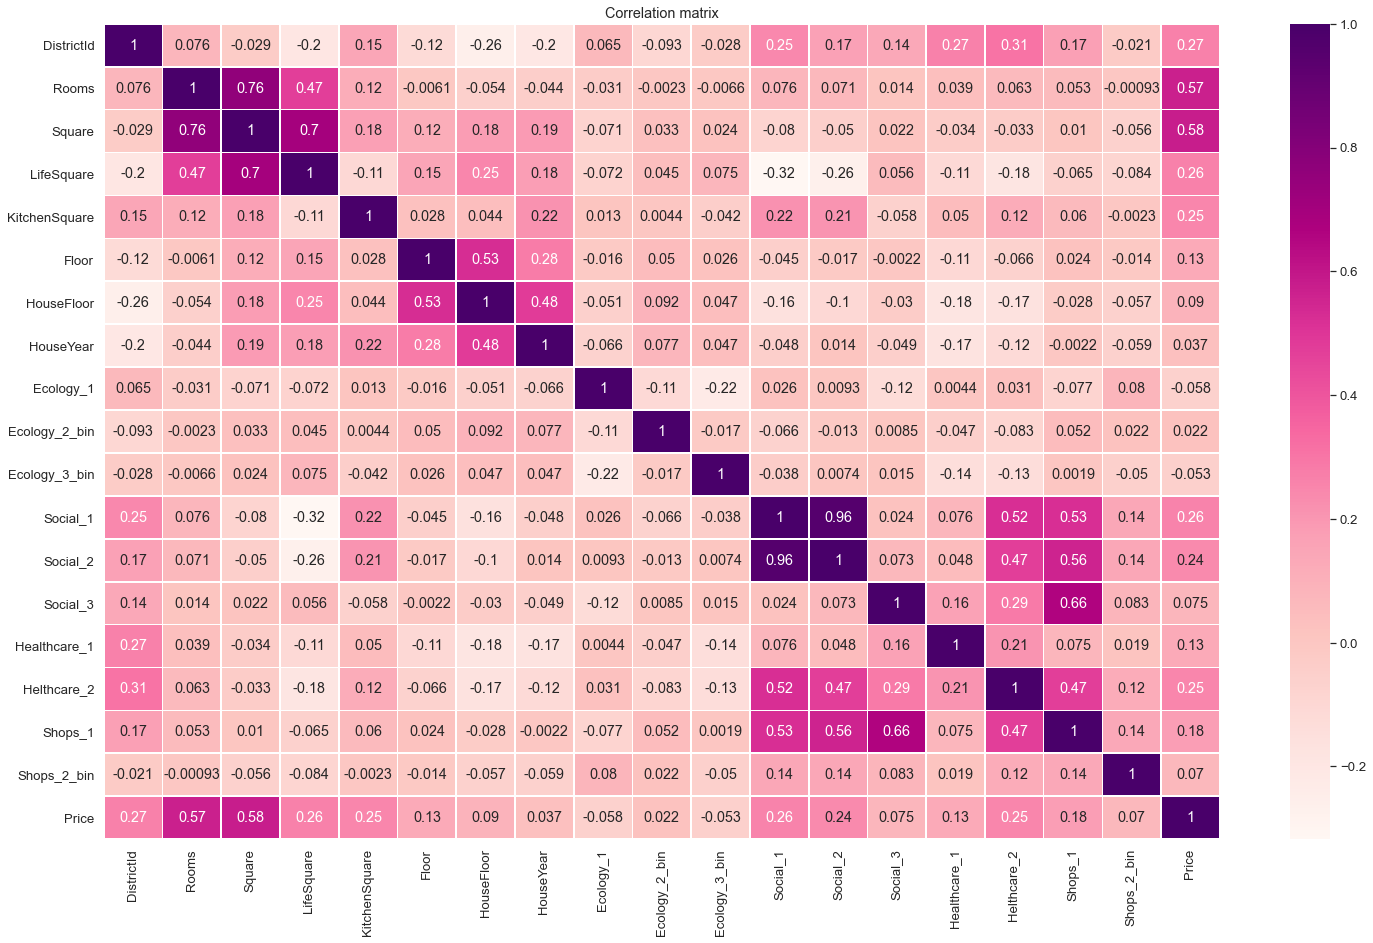

In [46]:
plt.figure(figsize=(25,15))

sns.set(font_scale=1.2)
sns.heatmap(Train_df[feature_names + ['Price']].corr(), annot=True, linewidths=.7, cmap='RdPu')

plt.title('Correlation matrix')
plt.show()

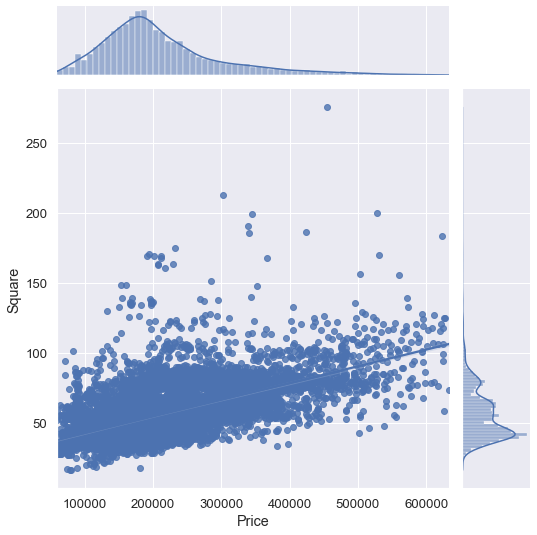

In [47]:
grid = sns.jointplot(Train_df[target_name], Train_df['Square'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

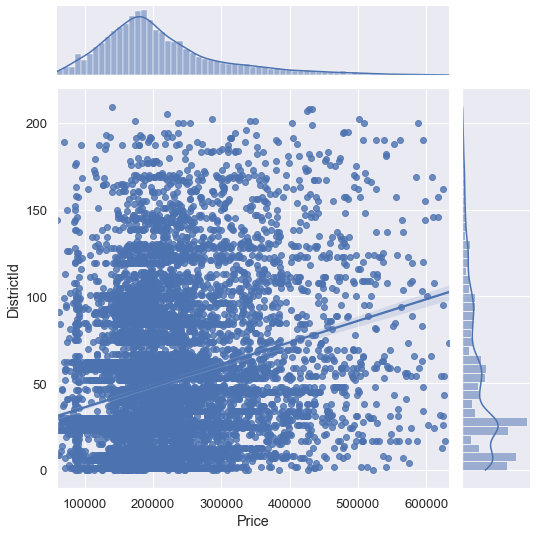

In [48]:
grid = sns.jointplot(Train_df[target_name], Train_df['DistrictId'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

#### Стандартизация признаков

In [49]:
feature_names_for_stand = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Social_1', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1']


In [50]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(Train_df[feature_names_for_stand])
stand_features_test = scaler.fit_transform(Test_df[feature_names_for_stand])

In [51]:
Train_df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)
Test_df[feature_names_for_stand] = pd.DataFrame(stand_features_test, columns=feature_names_for_stand)
Train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2_bin,Ecology_3_bin,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2_bin,Price
0,-0.536895,1.370628,3.085284,0.693230,0.838039,-0.863728,-0.674553,1.582710,-0.364931,1,1,-0.780698,3097,-0.337347,-0.169240,-0.883480,-0.880402,1,305018.871089
1,-0.651613,-1.095417,-0.860325,-1.042396,0.356960,-0.291306,-1.026295,-1.024702,-0.002690,1,1,0.303050,6207,-0.295384,0.209799,-0.213923,-0.880402,1,177734.553407
2,-1.133425,1.370628,1.160350,0.406878,0.838039,-1.245343,0.556544,0.170362,-0.783473,1,1,0.474169,5261,-0.337347,-1.053217,1.125190,-0.672333,1,282078.720850
3,-1.133425,-1.095417,-0.830028,0.693230,-0.845736,0.281117,1.435899,-0.427170,-0.938799,1,1,-1.351093,264,-0.337347,-0.169240,-0.883480,-0.672333,1,168106.007630
4,1.000316,0.137605,0.422745,-0.131923,0.597500,1.425961,0.380673,-0.698776,1.377425,1,1,0.474169,8667,-0.253421,-0.169240,-0.883480,0.368011,1,343995.102962


In [52]:
Train_df.std()

DistrictId           1.000050
Rooms                1.000050
Square               1.000050
LifeSquare           1.000050
KitchenSquare        1.000050
Floor                1.000050
HouseFloor           1.000050
HouseYear            1.000050
Ecology_1            1.000050
Ecology_2_bin        0.098015
Ecology_3_bin        0.163543
Social_1             1.000050
Social_2          4006.799803
Social_3             1.000050
Healthcare_1         1.000050
Helthcare_2          1.000050
Shops_1              1.000050
Shops_2_bin          0.275139
Price            92872.293865
dtype: float64

#### Разбиение на train и test

In [53]:
Train_df = Train_df[feature_names + [target_name]]
Test_df = Test_df[feature_names]
X = Train_df[feature_names]
y = Train_df[target_name]

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=100)

### Построение модели

In [55]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'KitchenSquare', 'Floor', 'HouseYear',
                 'Ecology_1', 'Social_1', 'Social_3',
                 'Healthcare_1', 'Helthcare_2']

In [56]:
X = Train_df[feature_names]
y = Train_df[target_name]

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=100)

In [61]:
final_model = CatBoostRegressor(
    silent=True,
    learning_rate=0.025,
    iterations=2500,
    eval_metric='R2',
    depth=8
)

final_model.fit(X, y)

cv_score = cross_val_score(
    final_model,
    X,
    y,
    scoring='r2',
    cv=KFold(
            n_splits=5,
            shuffle=True,
            random_state=65
    )
)

print(f'R2: {round(cv_score.mean(), 3)}')

R2: 0.753


#### Важность признаков

In [62]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances.head(20)

,feature_name,importance
2,Square,25.682615
7,Social_1,13.077746
8,Social_3,11.211356
0,DistrictId,9.807007
6,Ecology_1,9.279397
5,HouseYear,8.060173
3,KitchenSquare,6.563135
9,Healthcare_1,5.239447
4,Floor,4.757900
1,Rooms,3.685202


Применение модели на тестовом датасете

In [63]:
y_test_preds = final_model.predict(Test_df[feature_names])
Test_df = pd.read_csv('C:/Users/rsh/Desktop/Библиотеки Python/jupiter/Course_project/Dataset/test.csv')

In [64]:
result = pd.DataFrame()
result['Id'] = Test_df['Id'].copy()
result['Price'] = pd.Series(y_test_preds)

In [65]:
result.to_csv('C:/Users/rsh/Desktop/Библиотеки Python/jupiter/Course_project/RNiyazova_predictions.csv', index=False, encoding='utf-8')
result.head()

,Id,Price
0,4567,164414.308725
1,5925,120903.059529
2,960,152059.820617
3,3848,117102.422166
4,746,181099.075513


In [ ]:
# ник на Kaggle: Anna.NR